In [1]:
import sys
import os
import pandas as pd
import IPython.display as ipd
import numpy as np
from PyEMD import EEMD

module_path = os.path.abspath(os.path.join('..'))

sys.path.insert(1, module_path + '/src')
import utility

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))

from sktime.utils.data_io import load_from_tsfile_to_dataframe

figure_path = module_path + '/figures/'

target_rate = 41000

In [14]:
audio_file = '/home/andrine/Desktop/dataTromso/Hasse413/10000708_lungelyd_5.wav'

sr, audio = utility.read_wav_file(audio_file, target_rate)
audio = utility.denoise_audio(audio)
audio, sr = utility.downsample(audio, sr, 5000), 5000

duration = float(len(unfiltered)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N +1 )

In [15]:
import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import butter, lfilter

lowcut = 150
highcut = 1950
FRAME_RATE = 5000

highcut_2 = 50

def butter_lowpass(highcut, fs, order = 5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #b, a = butter_lowpass(highcut, fs, order = order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=6)


audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
audio = znorm(audio)
#wavfile.write(module_path + '/notebooks/filtered.wav', FRAME_RATE, filtered)
#wavfile.write(module_path + '/notebooks/unfiltered.wav', FRAME_RATE, audio)

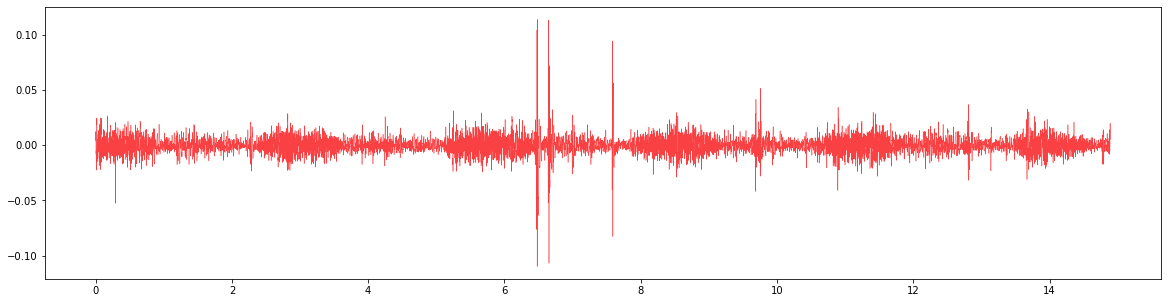

In [6]:
f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


duration = float(len(unfiltered)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N +1 )

if len(x) != len(unfiltered):
    x = np.linspace(0.0, N*T, N)

ax.plot(x, unfiltered, linewidth = 0.5)

ipd.Audio(unfiltered, rate = sr)

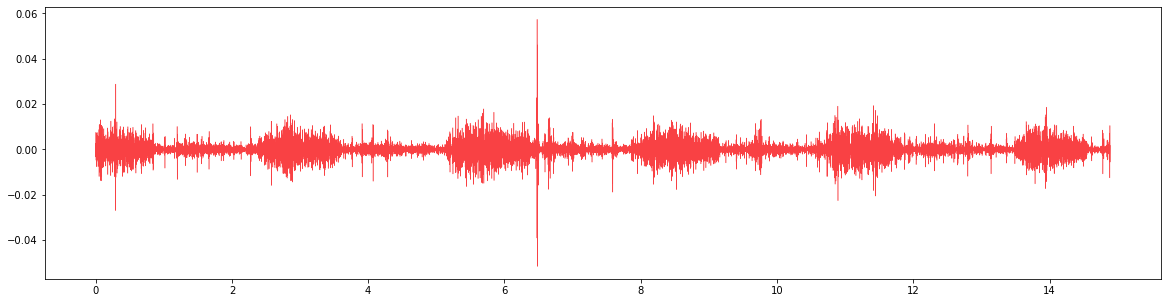

In [23]:
f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


ax.plot(x, filtered, linewidth = 0.5)

ipd.Audio(filtered, rate = sr)

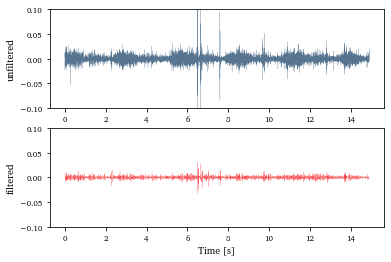

In [8]:
plot_dict = {
    'unfiltered' : unfiltered, 
    'filtered': filtered
}

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

f, axs = plt.subplots(2,1)
f.set_size_inches(6, 4)

for name, ax in zip(plot_dict.keys(), axs):
    #audio = znorm(sound)
    #audio = labels[name]
    audio = plot_dict[name]
    
    duration = float(len(audio)) / sr
    T = 1.0/sr
    N = int(duration / T)
    x = np.linspace(0.0, N*T, N +1 )
    if len(x) != len(audio):
        x = np.linspace(0.0, N*T, N)
    
    if name == 'unfiltered':
        ax.plot(x, audio, linewidth = 0.2, c = colors[2])
    else:
        ax.plot(x, audio, linewidth = 0.2, c = colors[0])
    ax.set_ylim(-0.1, 0.1)
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font_small)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font_small)
    ax.set_ylabel(f'{name}', fontproperties = font)
    ax.set_xlabel('Time [s]', fontproperties = font)

f.savefig(figure_path + f'filtered_heart_sound.pdf', bbox_inches='tight')

In [38]:
import scipy.fftpack
import random
import librosa


def make_synthetic(audio, sr):
    random_offset = random.random()
    test = 5*librosa.tone(400, sr=sr, length=1*sr, phi = random_offset)
    random_index = random.randint(0, len(audio) - len(test))
    new_audio = audio.copy()
    new_audio[random_index : random_index + len(test)] = new_audio[random_index : random_index + len(test)]  + test  
    return new_audio, random_index

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

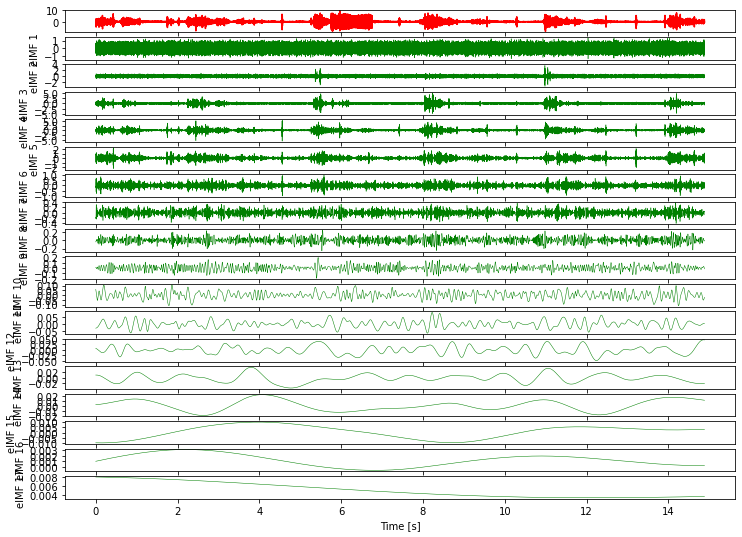

In [40]:
m_imf = 20
m_sift = 150
m_trials = 2
# Say we want detect extrema using parabolic method
eemd = EEMD(trials=m_trials)
eemd.spline_kind="slinear"
eemd.FIXE = m_sift


#filtered, index =  make_synthetic(audio, sr)
# Execute EEMD on S
eIMFs = eemd.eemd(audio, x, max_imf = m_imf)
nIMFs = eIMFs.shape[0]

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(x, filtered, 'r')

for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(x, eIMFs[n], 'g', linewidth = 0.5)
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time [s]")
plt.show()

In [37]:
x[index]

10.8896

In [18]:
index

66722

In [19]:

ipd.Audio(eIMFs[8] , rate = sr)

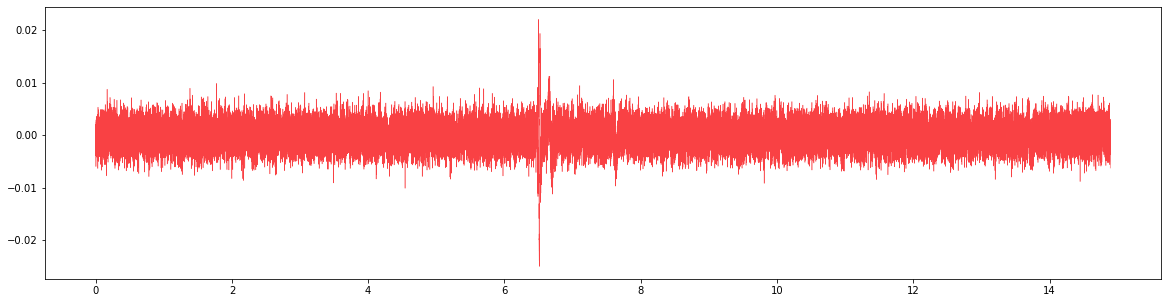

In [21]:
imf_sum = eIMFs[0] + eIMFs[1] + eIMFs[2] + eIMFs[3] + eIMFs[4] + eIMFs[8] + eIMFs[9] + eIMFs[10] + eIMFs[11] 
f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


ax.plot(x, imf_sum, linewidth = 0.5)


ipd.Audio( imf_sum, rate = sr)